# Allstate Severe Insurance Claim Competition: Initial Modeling

_Description: contains my initial modeling for the [Allstate Severe Insurance Claim Competition](https://www.kaggle.com/c/allstate-claims-severity)._

_Last Updated: 1/4/2016 5:11 PM._

_By: [Michael Rosenberg](https://www.kaggle.com/mmrosenb)._

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import cPickle as cpkl
from sklearn import preprocessing as pp
from sklearn import linear_model as lm
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Markdown, display #display settings
import warnings #for filtering warnings

#constants
%matplotlib inline
sns.set_style("dark")
#to ignore warnings in output
warnings.filterwarnings('ignore')
#global information settings
sigLev = 2 #three significant digits
percentMul = 100 #for percentage multiplication
figWidth = figHeight = 8

For now, I hope to perform some initial modeling with the top thirty features that I generated from my [Summary Statistics notebook](summaryStatistics.ipynb). We will start by doing a simple linear regression and some diagnostics using that linear regression with the top thirty features.

In [2]:
#load dataset and feature list
trainFrame = pd.read_csv("../data/train.csv")
testFrame = pd.read_csv("../data/test.csv")
initialFeatureList = cpkl.load(open("../data/featureList.pkl","rb"))

## Initial Modeling: Target $\log(Loss)$

Since my [Summary Statistics notebook](summaryStatistics.ipynb) initially found the loss variable to be incredibly right skewed (see Figure 1), I want to see if it may be reasonable to try and fit an initial linear model targeting $\log(Loss)$ and then transfering my predictions to $loss$ format with an after-the-fact transformation. Let us see how well this method performs.

In [3]:
trainFrame["logLoss"] = np.log(trainFrame["loss"])
initialMod_lm = lm.LinearRegression()
#get predictors
def factorizeVariable(varName,featureFrame):
    #helper that factorizes a variable in featureFrame and then returns the
    #feature frame with that new factorization
    labelEncoder = pp.LabelEncoder()
    intEncoding = labelEncoder.fit_transform(featureFrame[varName])
    #then make dummary variables
    uniqueLevels = labelEncoder.classes_
    for i in xrange(len(uniqueLevels) - 1): #can't be perfectly colinear
        dummyVarName = varName + "_" + uniqueLevels[i]
        featureFrame[dummyVarName] = 0
        featureFrame.loc[intEncoding == i,dummyVarName] = 1
    #then drop original var name
    featureFrame = featureFrame.drop(varName,axis = 1)
    return featureFrame
featureSet = trainFrame[initialFeatureList]
#the run factorization procedure
for feature in initialFeatureList:
    featureSet = factorizeVariable(feature,featureSet)

In [4]:
#then make predictions
targetVar = trainFrame["logLoss"]
initialMod_lm.fit(featureSet,targetVar)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [5]:
#build objective function
def mae(actualTarget,predictedTarget):
    #calculates mean absolute error
    absVec = np.abs(actualTarget - predictedTarget)
    mae = (float(1) / absVec.shape[0]) * np.sum(absVec)
    return mae
#get our test feature set for making predictions
testFeatureSet = testFrame[initialFeatureList]
for feature in initialFeatureList:
    testFeatureSet = factorizeVariable(feature,testFeatureSet)

In [6]:
#then make predictions
testLogPredictions = initialMod_lm.predict(testFeatureSet)
testPredictions = np.exp(testLogPredictions)
print testLogPredictions
print testPredictions

[ -3.53401046e+09  -1.36478725e+10   9.95227594e+00 ...,   2.37617345e+10
  -3.53401046e+09  -3.53401046e+09]
[     0.              0.          20999.96264957 ...,             inf
      0.              0.        ]


We see that predicting on log is really, really bad for output. Let us focus on $Loss$ rather than $\log(Loss).$

In [7]:
#refit
targetVar = trainFrame["loss"]
initialMod_lm.fit(featureSet,targetVar)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
testPredictions = initialMod_lm.predict(testFeatureSet)
print testPredictions

[ -3.09400206e+11  -4.82140281e+13   1.26524319e+04 ...,   9.61186560e+13
  -3.09400206e+11  -3.09400202e+11]


It looks like our predictions are exploding on the test set. Nonetheless, let us simply submit these for an attempt.

In [9]:
submission = pd.DataFrame({"id":list(testFrame["id"]),
                           "loss":testPredictions})
submission.to_csv("../data/initialSubmission.csv",index = False)

As expected, we are performing extremely badly on this initial submission. Let us check the Mean Absolute Error (MAE) on our training set.

In [10]:
trainPredictions = initialMod_lm.predict(featureSet)
trainMAE = mae(trainPredictions,targetVar)

We see that the training MAE is {{trainMAE}}. When we look at our [summary statistics](summaryStatistics.ipynb), or about {{np.log(trainMAE)}} on the $\log$ scale. Given that $\log(Loss)$ is primarily within the $6$ to $10$ range, it suggests to me that we still have a long way to go to produce strong predictions.

Let us see how large our coefficients are.

In [11]:
coefFrame = pd.DataFrame({"Name":featureSet.columns,
                           "Coefficient":initialMod_lm.coef_})
coefFrame = coefFrame.sort_values("Coefficient")
display(coefFrame)

,Coefficient,Name
17,-4.168943e+15,cat81_A
21,-5.697031e+14,cat7_A
55,-1.769137e+14,cat111_A
29,-7.187035e+13,cat3_A
70,-4.821403e+13,cat5_A
27,-4.790463e+13,cat89_G
26,-4.790463e+13,cat89_E
24,-4.790463e+13,cat89_C
23,-4.790463e+13,cat89_B
25,-4.790463e+13,cat89_D


_Table 1: Coefficients of Our Initial Model._

It is apparent that the current linear regression is featuring some exploding coefficients, possibly driven by particular outliers. This suggests to me that the first thing we should probably do is regularize the size of these coefficients through a LASSO variation of our regression.

In [12]:
initialMod_lasso = lm.Lasso()
initialMod_lasso.fit(featureSet,targetVar)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [13]:
def makeSubmission(testFrame,testFeatureSet,givenModel,
                   csvName = "newSubmission.csv"):
    #helper that creates a new submission for us
    testPredictions = givenModel.predict(testFeatureSet) 
    submission = pd.DataFrame({"id":list(testFrame["id"]),
                           "loss":testPredictions})
    submission.to_csv("../data/" + csvName,index = False)
makeSubmission(testFrame,testFeatureSet,initialMod_lasso,
               "initialLassoSubmission.csv")

Interestingly, this submission has improved significantly on the test set compared to our previous submission, partially due to the fact we reduced overfitting significantly. Let us study diagnostics of this on the training data.

## LASSO Regression: Diagnostics

In [14]:
#then check mae
lassoMAE = mae(initialMod_lasso.predict(featureSet),targetVar)

Our LASSO regression has an MAE of {{lassoMAE}}. This is close to the MAE of our OLS regression, which suggests that we are performing about on-par on the training data, although after the MAE analysis on the OLS regression, it's still not an incredible fit for the data. Let us study the coefficients on the LASSO regression.

In [15]:
#get number of coefficients that are non-zero
coefVec = initialMod_lasso.coef_
nonZeroEntries = np.where(coefVec != 0)[0]

We see that {{nonZeroEntries.shape[0]}} of the {{coefVec.shape[0]}} considered are given predictive abilities in the regression. This does suggest that we are getting rid of a good portion of unnecessary multicolinearities that appeared in our initial linear regression. Let us study which features have been the highest and lowest coefficients in these {{nonZeroEntries.shape[0]}} features.

In [16]:
columnsConsidered = list(featureSet.columns[nonZeroEntries])
coefficientsConsidered = coefVec[nonZeroEntries]
coefFrame = pd.DataFrame({"Feature_Name":columnsConsidered,
                          "Coefficient":coefficientsConsidered})
#then order
coefFrame = coefFrame.sort_values("Coefficient",ascending = False)
display(coefFrame)

,Coefficient,Feature_Name
1,1112.244115,cat80_B
16,728.955619,cat81_C
15,697.256839,cat81_B
41,673.943582,cat111_M
31,519.220707,cat103_G
2,474.767531,cat80_C
45,423.912157,cat40_A
6,413.316502,cat1_A
0,405.450914,cat80_A
40,391.146660,cat111_K


_Table 2: Features with non-zero coefficients from our LASSO regression._

We do see that our top 5 highest correlated variables (see [summary statistics](summaryStatistics.ipynb)) do show up having predictive power in this regression, which provides more evidence for their usefulness in this regression. We see that slightly more coefficients provide negative effects, which is slightly worrisome since this may suggest negative $Loss$ predictions. We also see that `cat57_A` provides an extremely negative effect, which is unusual relative to the rest of the cofficients that are more around the $[-1500,1200]$ range.

Let us study how well we are predicting over different target levels.

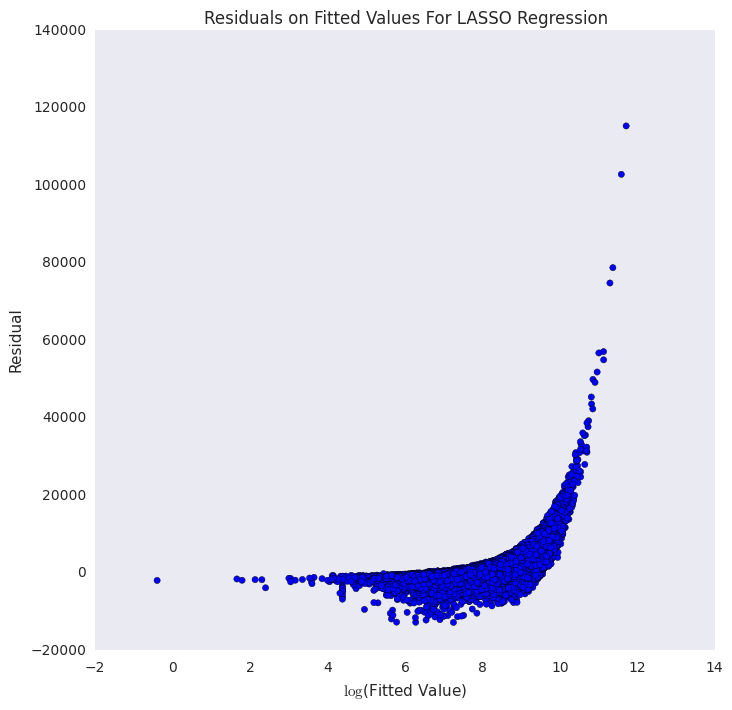

In [18]:
#make residual-target plot
residuals = targetVar - initialMod_lasso.predict(featureSet)
#make residuals on target variable
givenFig = plt.figure(figsize = (figWidth,figHeight))
plt.scatter(np.log(targetVar),residuals)
plt.xlabel("$\log$(Fitted Value)")
plt.ylabel("Residual")
plt.title("Residuals on Fitted Values For LASSO Regression")

_Figure 1: Residuals on Log Fitted Values._

Interestingly, we see that while we are doing some sizable underprediction in $6$ to $9$ range of $\log(\text{Fitted Value})$, it is apparent that we are doing severe underprediction at the high end of our fitted values. This may suggest some exponential effect occuring in the increases of true values, and these outliers may be pulling up our MAE. Let us check how severely they are affecting our training MAE by removing all observations with residuals above $40000$ from our training set, refitting our model, and then seeing the changes in MAE that occur. Of course, if we were doing a formal outlier analysis, we would use a much more meaningful measure of outlier detection.

In [43]:
outlierCutoff = 40000
nonOutlierRows = list(np.where(residuals < outlierCutoff)[0])
nonOutlierFeatureSet = featureSet.iloc[nonOutlierRows,:]
nonOutlierTargetVar = targetVar.iloc[nonOutlierRows]

In [44]:
nonOutlierMod_lasso = lm.Lasso()
nonOutlierMod_lasso.fit(nonOutlierFeatureSet,nonOutlierTargetVar)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [47]:
nonOutlierLassoMAE = mae(nonOutlierMod_lasso.predict(nonOutlierFeatureSet),
                         nonOutlierTargetVar)

We are getting an MAE of {{nonOutlierLassoMAE}} on our current training set, which is not a great reduction in MAE. To some degree it looks like we should be considering some potential non-linearities that could exist within the main dataset.

In [46]:
makeSubmission(testFrame,testFeatureSet,nonOutlierMod_lasso,
               "lassoWithTrainingOutliersRemovedSubmission.csv")

## Kernel Ridge Regression

We will now attempt to use a kernel ridge regression with the parameters that were given non-zero coefficient